# Fully Convolutional Network for Semantic Segmentation  
- FCN for semantic segmentation 논문 구현
- data : kaggle  

### package and module

In [1]:
# package and module
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose, concatenate, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Load data and preprocessing

In [4]:
# data load
train_path = os.path.join('./city_data/train')
test_path = os.path.join('./city_data/val')

# image path
train_dir = os.listdir(train_path)
test_dir = os.listdir(test_path)

# image files
train_files = [os.path.join(train_path, fname)
               for fname in train_dir]
test_files = [os.path.join(test_path, fname)
               for fname in test_dir]

In [5]:
width = 256
height = 256
n_classes = 13

In [6]:
# load image data
def load_image(files):
    # create empty list
    image_list, mask_list = [], []
    for file in files:
        # open each image
        img = Image.open(os.path.join(file))
        # transfer array type
        img = np.array(img)
        # original image has an image and a mask together
        # so we divide the image in half
        image = img[:,:width]
        mask = img[:,width:]
        image_list.append(image)
        mask_list.append(mask)
    # return images data and masks data
    return np.array(image_list), np.array(mask_list)

train_image, train_mask = load_image(train_files)
test_image, test_mask = load_image(test_files)

In [7]:
# make 13 classes segmentation images
def make_segmentation(mask_data_set, n_classes=13):
    changed_mask_list = []
    for i in tqdm(range(len(mask_data_set))):
        ranges = np.arange(20,241,20)
        # divide a range
        new_mask = np.digitize(mask_data_set[i], ranges)
        # the original mask has an 13 channels
        seg_labels = np.zeros((width,height,n_classes))
        img = new_mask[:,:,0]
        for j in range(n_classes):
            seg_labels[:,:,j] = (img==j).astype(int)
        changed_mask_list.append(seg_labels)
    return np.array(changed_mask_list)

train_mask = make_segmentation(train_mask)
test_mask = make_segmentation(test_mask)

  0%|          | 0/2975 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

### Build FCN network

In [8]:
# load vgg16 model
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(width,height,3))

# define encoder model function
def encoder(vgg):
    ## define skip layers
    skip1 = vgg.get_layer('block3_pool').output
    skip2 = vgg.get_layer('block4_pool').output
    skip3 = vgg.get_layer('block5_pool').output
    
    ## build two 1x1 convolution layers with batch normalization layer
    x = Conv2D(1024, (7,7), padding='same', activation='relu')(skip3)
    x = BatchNormalization()(x)
    x = Conv2D(1024, (1,1), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    
    # define encoder model
    encoder_model = Model(inputs=[vgg.input], outputs=[x])
    
    # we need encoder model and first skip layer and second skip layer
    return encoder_model, skip1, skip2

In [9]:
# define decoder with skip layer
def decoder(skip_layers_with_model, n_classes=13, fcn_32s=False, fcn_16s=False, fcn_8s=True):
    ## load skip layers ##
    encoder, skip1, skip2 = skip_layers_with_model
    
    if fcn_32s==True:
        ## build fcn-32s network ##
        up_samp_32 = Conv2DTranspose(n_classes, (32,32), strides=32, activation='softmax')(encoder.output)
        model = Model(inputs=[encoder.input], outputs=[up_samp_32])
    
    elif fcn_16s==True:
        ## build fcn-16s network ##
        conv7_x2 = Conv2DTranspose(n_classes, (2,2), strides=2)(encoder.output)
        pool4 = Conv2D(n_classes, (1,1), padding='same', activation='relu')(skip2)
        merge = concatenate([pool4, conv7_x2])
        up_samp_16 = Conv2DTranspose(n_classes, (16,16), strides=16, activation='softmax')(merge)
        model = Model(inputs=[encoder.input], outputs=[up_samp_16])
        
    elif fcn_8s==True:
        ## build fcn-8s network ##
        conv7_x4 = Conv2DTranspose(n_classes, (4,4), strides=4)(encoder.output)
        pool3 = Conv2D(n_classes, (1,1), padding='same', activation='relu')(skip1)
        pool4 = Conv2D(n_classes, (1,1), padding='same', activation='relu')(skip2)
        pool4_x2 = Conv2DTranspose(n_classes, (2,2), strides=2)(pool4)
        merge = concatenate([pool3, pool4_x2, conv7_x4])
        up_samp_8 = Conv2DTranspose(n_classes, (8,8), strides=8, activation='softmax')(merge)
        model = Model(inputs=[encoder.input], outputs=[up_samp_8])
    
    return model

In [10]:
# model
fcn_32s = decoder(encoder(vgg), n_classes=13, fcn_32s=True)
fcn_16s = decoder(encoder(vgg), n_classes=13, fcn_16s=True)
fcn_8s = decoder(encoder(vgg), n_classes=13)

In [11]:
fcn_32s.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [12]:
fcn_16s.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [13]:
fcn_8s.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

### Setting loss and optimizer by FCN paper  
- SGD momentum 0.9로 설정하고 학습해봤으나 성능이 너무 안좋아 Adam으로 진행

In [14]:
# setting optimizer and loss by fcn paper
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
#opt = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9, decay=5**-4)
fcn_32s.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
fcn_16s.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
fcn_8s.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [15]:
# setting early stopping
earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

In [16]:
# create generator
data_gen = ImageDataGenerator(rescale=1/255., validation_split=0.2)
data_gen.fit(train_image)

### Training FCN-32s and check result

In [17]:
# hyperparameter setting
EPOCH = 100
batch_size = 64

train_data = data_gen.flow(train_image, 
                           train_mask, 
                           batch_size=batch_size, 
                           subset='training')
validation_data = data_gen.flow(train_image, 
                                train_mask, 
                                batch_size=int(batch_size/4), 
                                subset='validation')

In [18]:
# fcn_32s model training
history1 = fcn_32s.fit_generator(train_data,
                                 epochs=EPOCH,
                                 validation_data=validation_data,
                                 callbacks=[earlystop])

Epoch 1/100
38/38 [==============================] - 86s 1s/step - loss: 1.8265 - accuracy: 0.5259 - val_loss: 1.6021 - val_accuracy: 0.5271
Epoch 2/100
38/38 [==============================] - 14s 370ms/step - loss: 1.2032 - accuracy: 0.6520 - val_loss: 1.3063 - val_accuracy: 0.6909
Epoch 3/100
38/38 [==============================] - 14s 376ms/step - loss: 0.9922 - accuracy: 0.7348 - val_loss: 1.1292 - val_accuracy: 0.7218
Epoch 4/100
38/38 [==============================] - 15s 401ms/step - loss: 0.8975 - accuracy: 0.7559 - val_loss: 1.0371 - val_accuracy: 0.7386
Epoch 5/100
38/38 [==============================] - 15s 396ms/step - loss: 0.8343 - accuracy: 0.7724 - val_loss: 0.9802 - val_accuracy: 0.7415
Epoch 6/100
38/38 [==============================] - 15s 401ms/step - loss: 0.7748 - accuracy: 0.7888 - val_loss: 0.9542 - val_accuracy: 0.7591
Epoch 7/100
38/38 [==============================] - 15s 383ms/step - loss: 0.7276 - accuracy: 0.8025 - val_loss: 0.9156 - val_accuracy: 0.

In [19]:
# predict test set
test_image = test_image/255.
prediction1 = fcn_32s.predict(test_image)

In [20]:
# check model performance
test_loss, test_acc = fcn_32s.evaluate(test_image, test_mask)
print(f'Error: {test_loss}, Accuracy: {round(test_acc*100)}%')

16/16 [==============================] - 1s 70ms/step - loss: 0.7990 - accuracy: 0.7951
Error: 0.7990478277206421, Accuracy: 80%


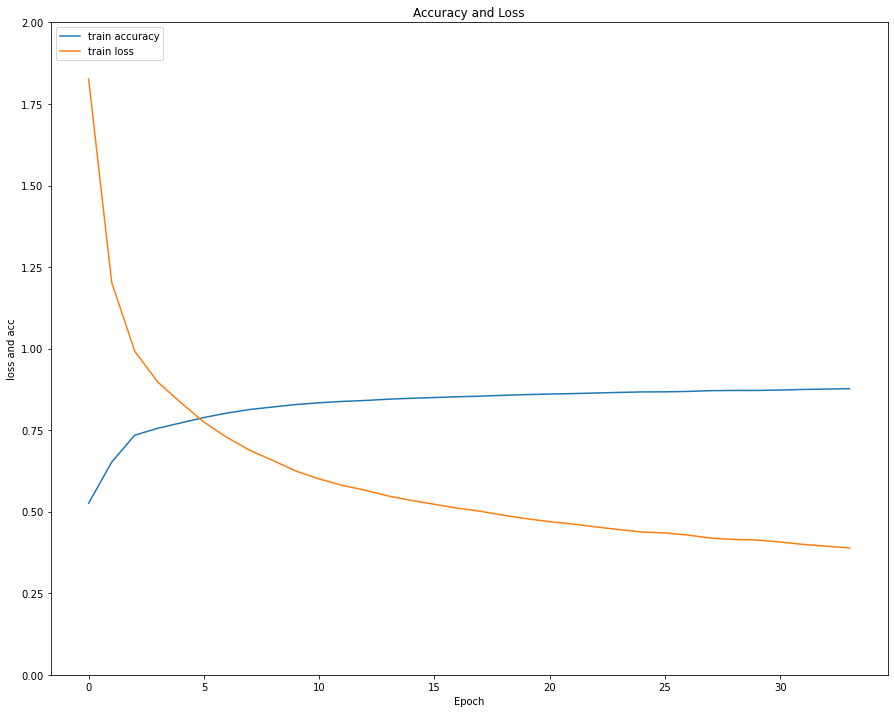

In [21]:
# show loss and accuracy
def show_loss_acc(history):
    plt.figure(figsize=(15,12))
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['loss'], label='train loss')
    plt.title('Accuracy and Loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss and acc')
    plt.ylim(0,2)
    plt.legend(loc='upper left')
    plt.show()
    
show_loss_acc(history1)

In [22]:
# 13 classes segmentation image to 3 color image
def seg_img_3_color(seg, n_classes=13):
    seg_img = np.zeros((seg.shape[0],seg.shape[1],3)).astype('float')
    colors = sns.color_palette("hls", n_classes)
    for c in range(n_classes):
        segc = (seg==c)
        seg_img[:,:,0] += (segc*(colors[c][0]))
        seg_img[:,:,1] += (segc*(colors[c][1]))
        seg_img[:,:,2] += (segc*(colors[c][2]))

    return seg_img

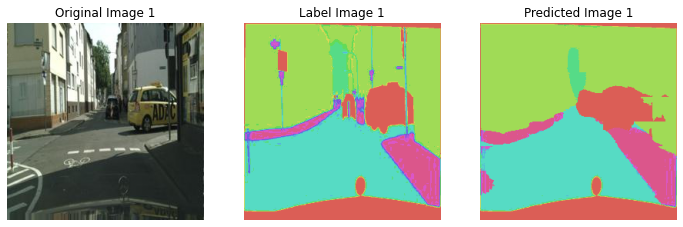

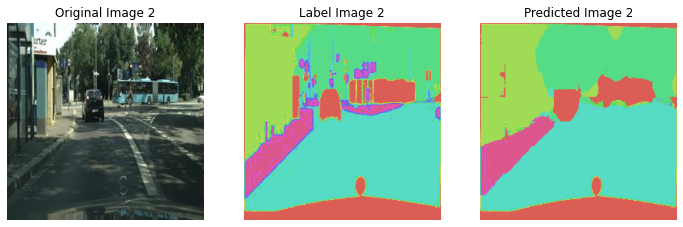

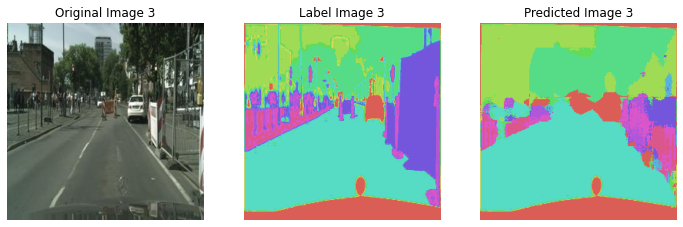

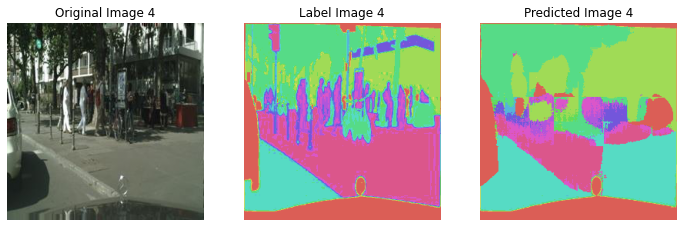

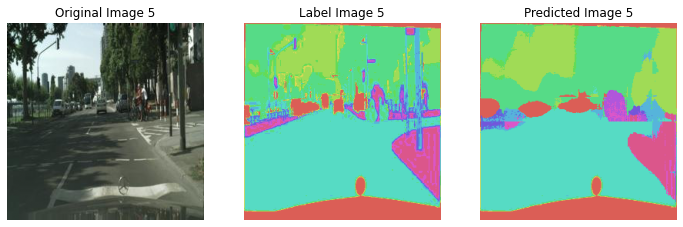

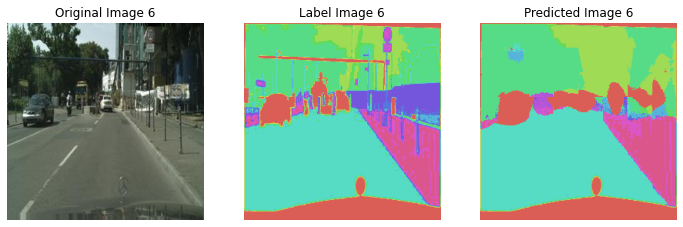

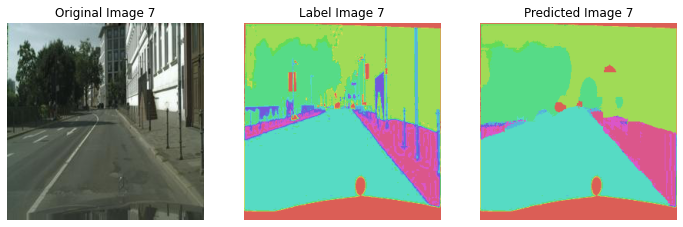

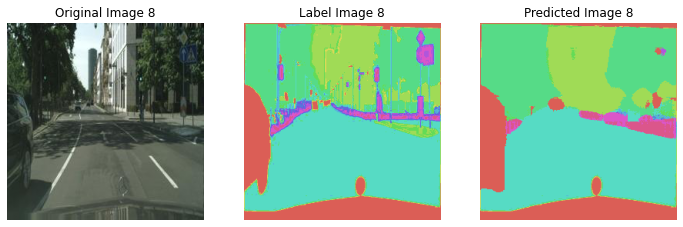

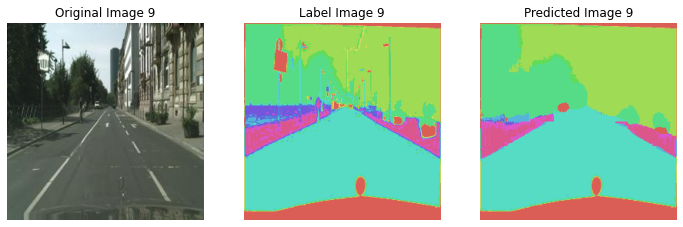

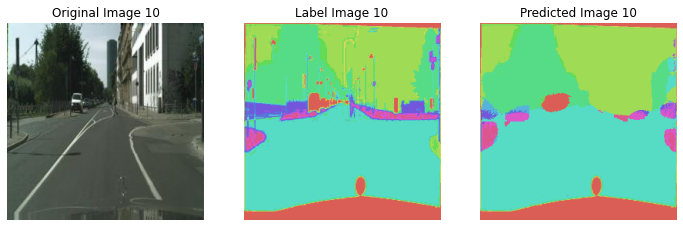

In [23]:
# check result of segmentation
def show_result(ncols, original, label, predicted):
    for i in range(ncols):
        plt.figure(figsize=(12,4))
        plt.subplot(131)
        plt.imshow(original[i])
        plt.title(f'Original Image {i+1}')
        plt.axis('off')
        plt.subplot(132)
        plt.imshow(seg_img_3_color(np.argmax(label[i], axis=-1)))
        plt.title(f'Label Image {i+1}')
        plt.axis('off')
        plt.subplot(133)
        plt.imshow(seg_img_3_color(np.argmax(predicted[i], axis=-1)))
        plt.title(f'Predicted Image {i+1}')
        plt.axis('off')
        
show_result(10, test_image, test_mask, prediction1)

### Training FCN-16s and check result

In [24]:
# fcn_16s model training
history2 = fcn_16s.fit_generator(train_data,
                                 epochs=EPOCH,
                                 validation_data=validation_data,
                                 callbacks=[earlystop])

Epoch 1/100
38/38 [==============================] - 15s 374ms/step - loss: 1.7933 - accuracy: 0.4313 - val_loss: 1.2764 - val_accuracy: 0.6205
Epoch 2/100
38/38 [==============================] - 15s 384ms/step - loss: 1.0560 - accuracy: 0.7032 - val_loss: 0.9871 - val_accuracy: 0.7177
Epoch 3/100
38/38 [==============================] - 15s 399ms/step - loss: 0.9021 - accuracy: 0.7444 - val_loss: 0.9308 - val_accuracy: 0.7392
Epoch 4/100
38/38 [==============================] - 14s 360ms/step - loss: 0.8348 - accuracy: 0.7613 - val_loss: 0.9094 - val_accuracy: 0.7432
Epoch 5/100
38/38 [==============================] - 14s 360ms/step - loss: 0.7788 - accuracy: 0.7735 - val_loss: 0.8788 - val_accuracy: 0.7517
Epoch 6/100
38/38 [==============================] - 14s 366ms/step - loss: 0.7408 - accuracy: 0.7839 - val_loss: 0.8444 - val_accuracy: 0.7590
Epoch 7/100
38/38 [==============================] - 14s 358ms/step - loss: 0.7012 - accuracy: 0.7944 - val_loss: 0.8386 - val_accuracy:

In [25]:
# predict test set
prediction2 = fcn_16s.predict(test_image)

In [26]:
# check model performance
test_loss, test_acc = fcn_16s.evaluate(test_image, test_mask)
print(f'Error: {test_loss}, Accuracy: {round(test_acc*100)}%')

16/16 [==============================] - 1s 71ms/step - loss: 0.7774 - accuracy: 0.7978
Error: 0.777369499206543, Accuracy: 80%


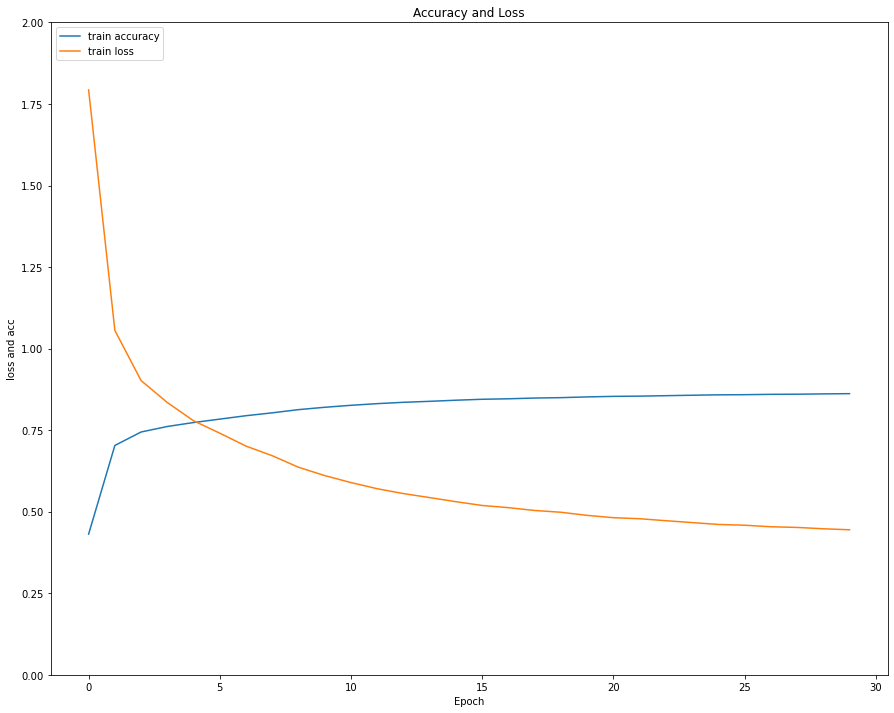

In [27]:
# check loss and accuracy
show_loss_acc(history2)

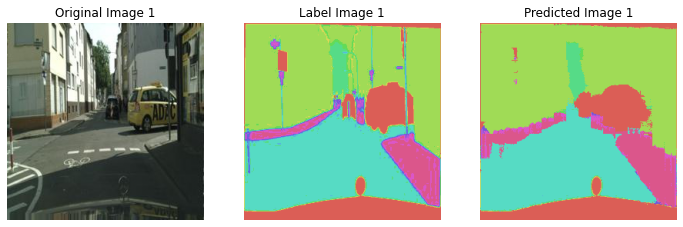

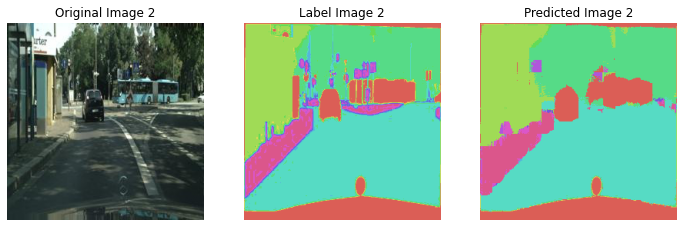

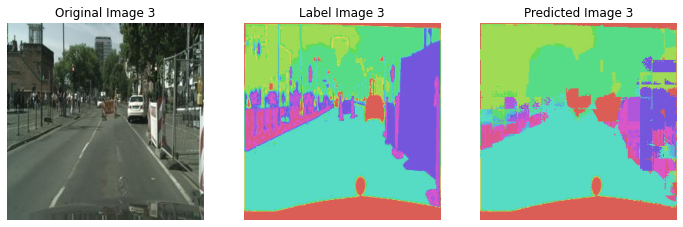

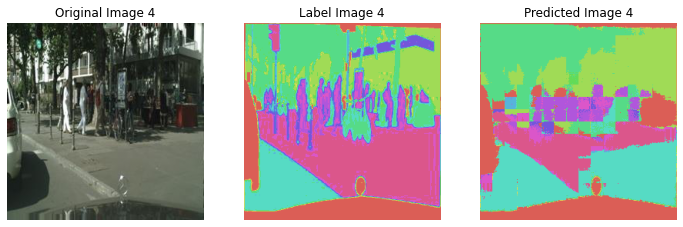

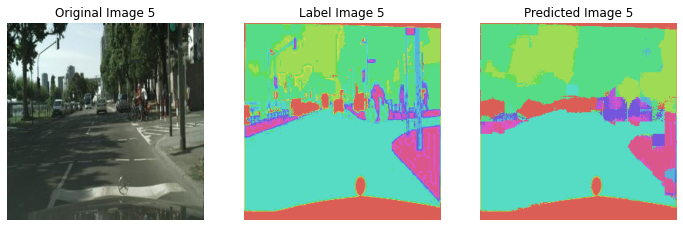

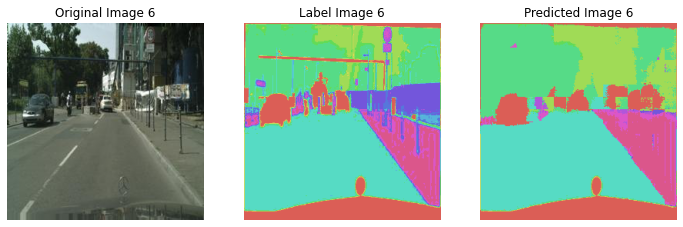

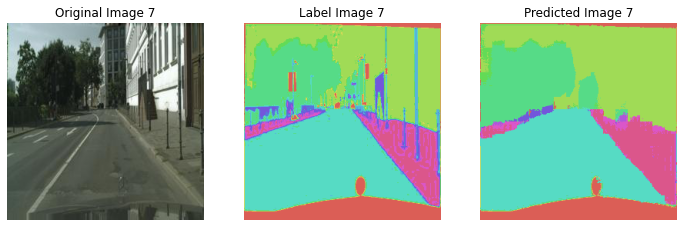

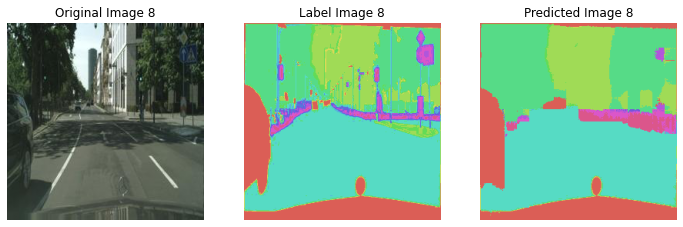

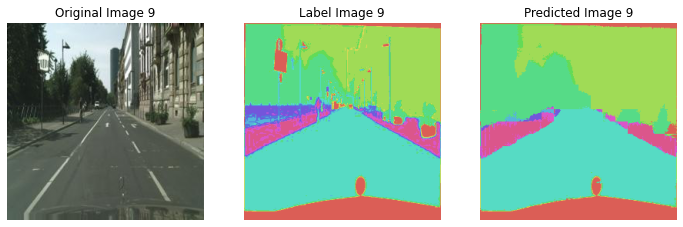

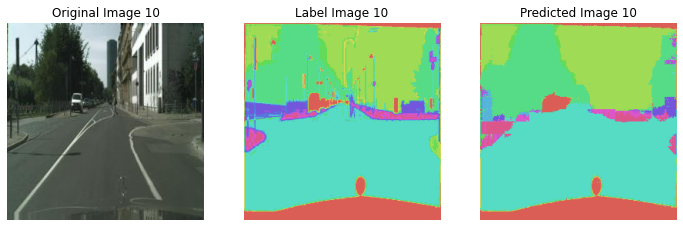

In [28]:
# check result of segmentation
show_result(10, test_image, test_mask, prediction2)

### Training FCN-8s and check result

In [29]:
# fcn_8s model training
history3 = fcn_8s.fit_generator(train_data,
                                epochs=EPOCH,
                                validation_data=validation_data,
                                callbacks=[earlystop])

Epoch 1/100
38/38 [==============================] - 16s 389ms/step - loss: 1.8818 - accuracy: 0.3873 - val_loss: 1.5984 - val_accuracy: 0.5353
Epoch 2/100
38/38 [==============================] - 15s 393ms/step - loss: 1.2000 - accuracy: 0.6440 - val_loss: 1.1081 - val_accuracy: 0.7012
Epoch 3/100
38/38 [==============================] - 15s 400ms/step - loss: 0.9961 - accuracy: 0.7226 - val_loss: 0.9824 - val_accuracy: 0.7214
Epoch 4/100
38/38 [==============================] - 15s 399ms/step - loss: 0.8996 - accuracy: 0.7447 - val_loss: 0.9778 - val_accuracy: 0.7373
Epoch 5/100
38/38 [==============================] - 16s 406ms/step - loss: 0.8305 - accuracy: 0.7656 - val_loss: 0.9599 - val_accuracy: 0.7458
Epoch 6/100
38/38 [==============================] - 16s 409ms/step - loss: 0.7674 - accuracy: 0.7809 - val_loss: 0.9429 - val_accuracy: 0.7472
Epoch 7/100
38/38 [==============================] - 15s 396ms/step - loss: 0.7202 - accuracy: 0.7913 - val_loss: 0.9347 - val_accuracy:

In [30]:
# predict test set
prediction3 = fcn_8s.predict(test_image)

In [31]:
# check model performance
test_loss, test_acc = fcn_8s.evaluate(test_image, test_mask)
print(f'Error: {test_loss}, Accuracy: {round(test_acc*100)}%')

16/16 [==============================] - 1s 71ms/step - loss: 0.8201 - accuracy: 0.7916
Error: 0.820121169090271, Accuracy: 79%


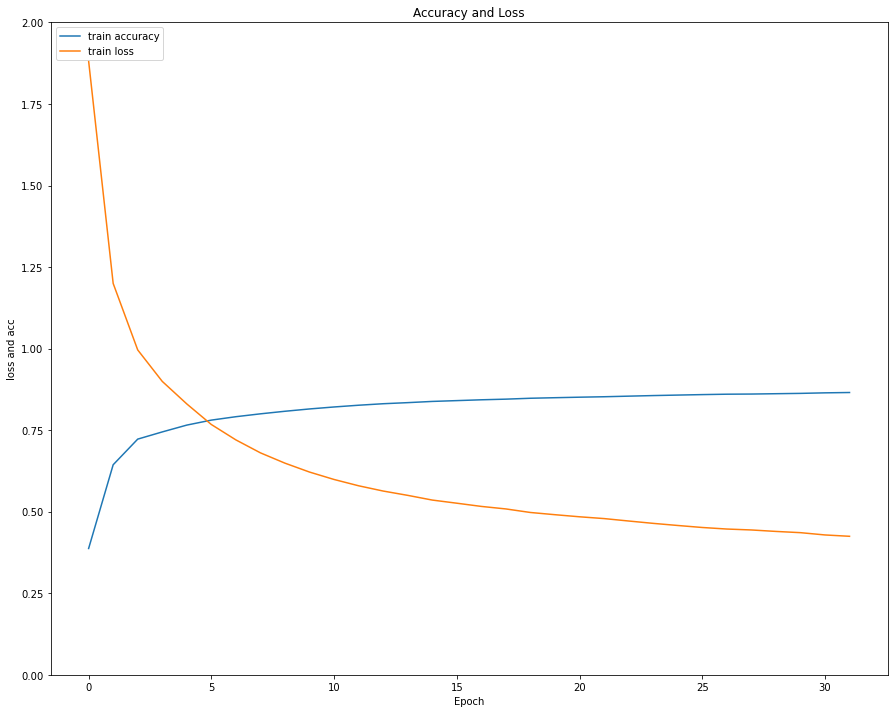

In [32]:
# check loss and accuracy
show_loss_acc(history3)

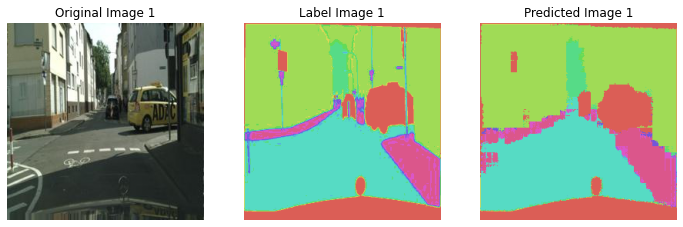

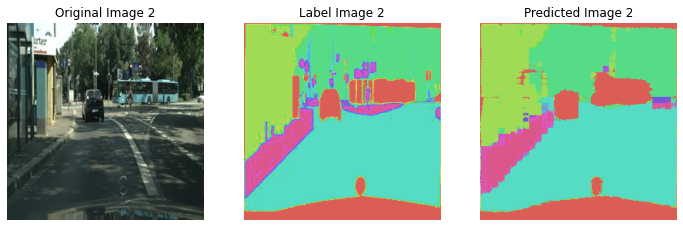

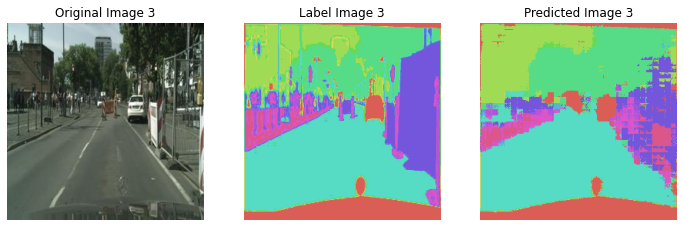

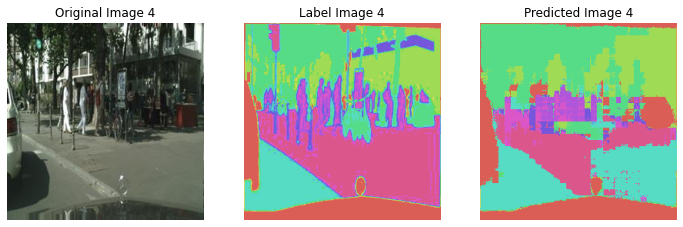

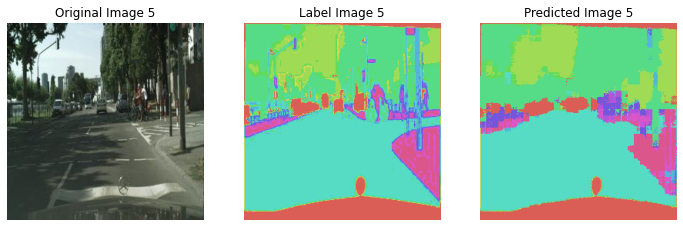

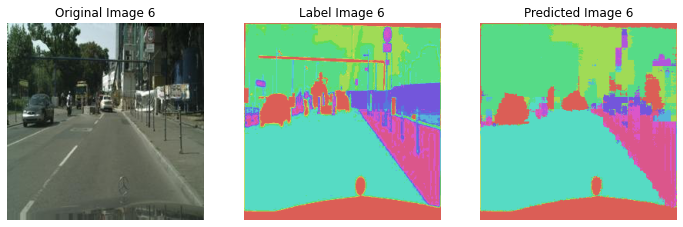

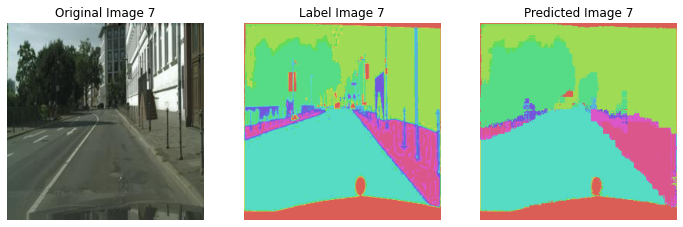

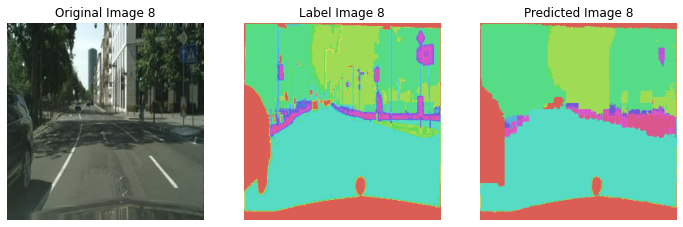

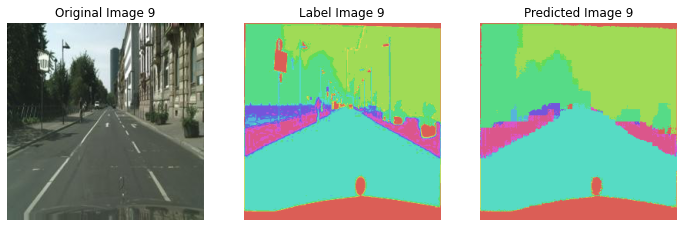

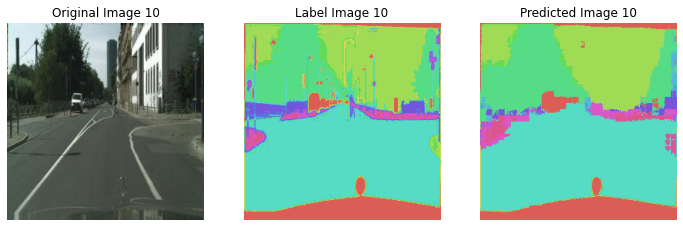

In [33]:
# check result of segmentation
show_result(10, test_image, test_mask, prediction3)

### FCN-32s, 16s, 8s 결과 같이 살펴보기

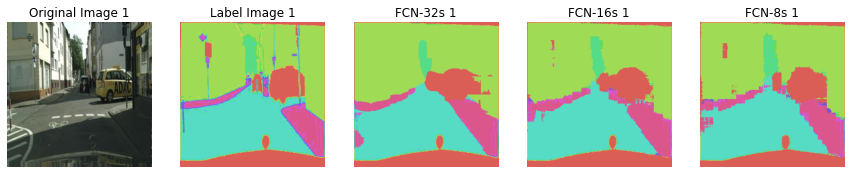

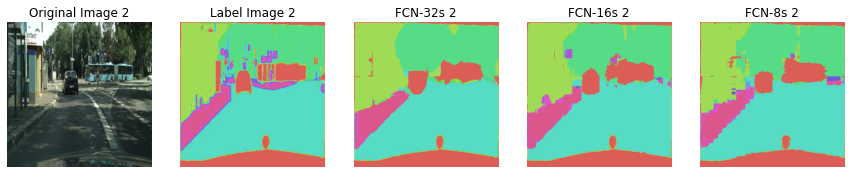

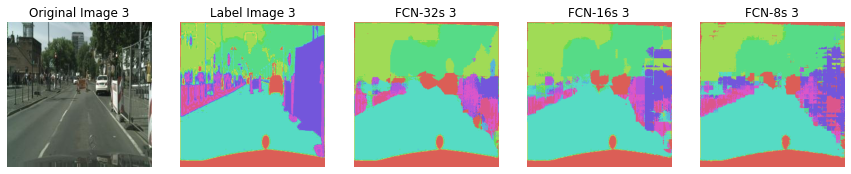

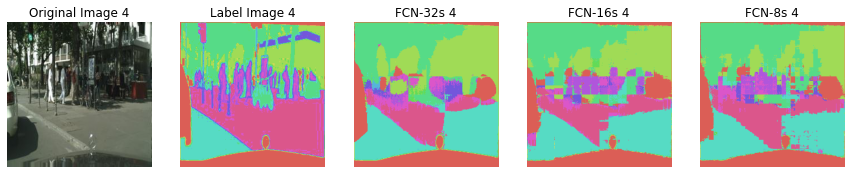

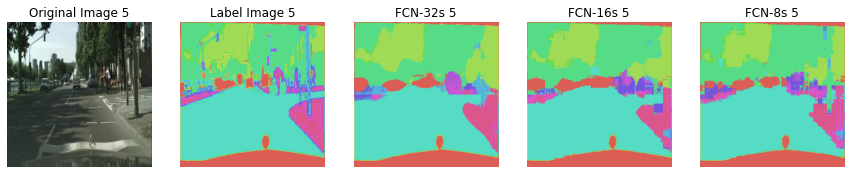

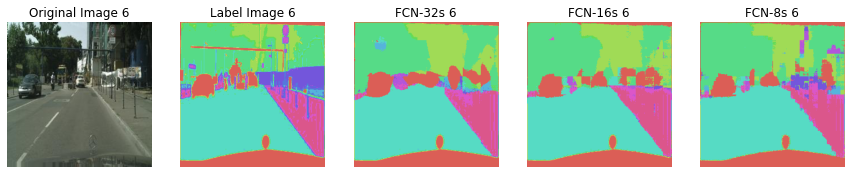

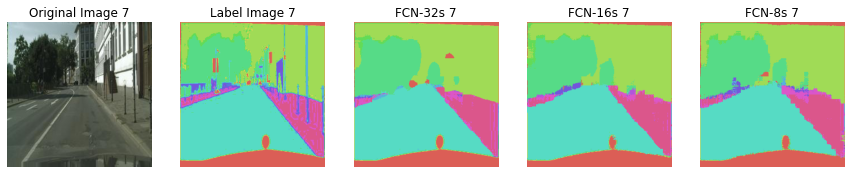

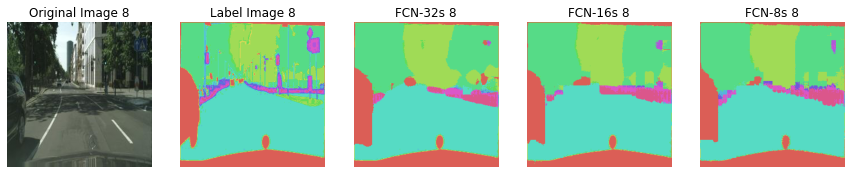

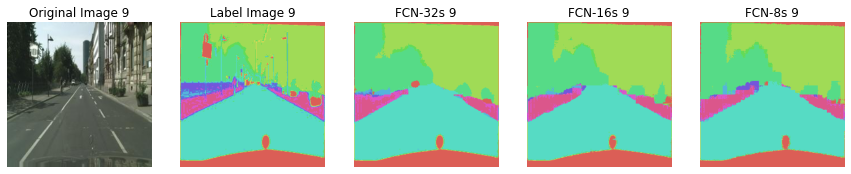

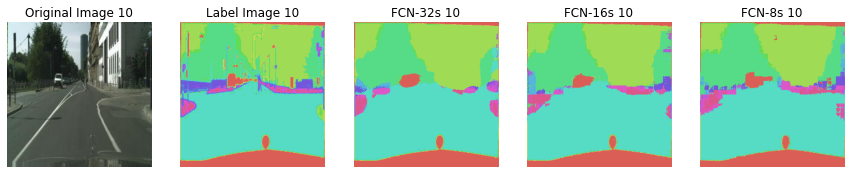

In [34]:
def fcns_result(ncols, fcn32, fcn16, fcn8):
    for i in range(ncols):
        plt.figure(figsize=(15,3))
        test_set = [test_image, test_mask, fcn32, fcn16, fcn8]
        set_name = ['Original Image', 'Label Image', 'FCN-32s', 'FCN-16s', 'FCN-8s']
        for j in range(len(test_set)):
            plt.subplot(1,5,j+1)
            if j==0:
                plt.imshow(test_set[j][i])
            else:
                plt.imshow(seg_img_3_color(np.argmax(test_set[j][i], axis=-1)))
            plt.title(set_name[j]+f' {i+1}')
            plt.axis('off')
        plt.show()
        
fcns_result(10, prediction1, prediction2, prediction3)